In [201]:
import pandas as pd
import numpy as np
import pytraj as pyt
import csv
import ast
import datetime
import matplotlib.pyplot as plt
from modulos.MDS import cMDS, cMDS_proj
from modulos.plotting_functions import density_estimation, plot_mds_or_pca, plot_anotation_labels

In [80]:
df_cdk2 = pd.read_csv("./B_DATOS/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO.csv", index_col = 0,
                     converters={"NameLigs": lambda x: ast.literal_eval(x),
                                "GapPos": lambda x: ast.literal_eval(x),
                                 "Date": lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d")),
                                 "NameLigs": lambda x: ast.literal_eval(x),
                                })
df_cdk2.set_index("PDB_ID", inplace=True)
df_cdk2.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
PDB_ID,,,,,,,,,,,,,,
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298.0,92.953020,2.0,"[8, 13]","[[36, 43], [149, 161]]",1.0,['STU'],STU,440.0
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0


In [81]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = "../ARCHIVOS/CRISTALES/TRAJ_CRISTALS_PDB/PDB_402_cdk2_PISANI_ALL.pdb"
traj_crystals = pyt.load(file_pdb_traj_pisani)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 4848.


In [82]:
# Función para etiquetar cada estructura
from modulos.label_cdk2_confs import label_cdk2_conformations
labels_cdk2 = label_cdk2_conformations(traj_crystals)
df_cdk2["Labels_conf"] = labels_cdk2
df_cdk2.head(5)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf
PDB_ID,,,,,,,,,,,,,,,
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298.0,92.953020,2.0,"[8, 13]","[[36, 43], [149, 161]]",1.0,['STU'],STU,440.0,inact_b
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298.0,96.308725,2.0,"[7, 4]","[[40, 46], [295, 298]]",0.0,[],NaN,NaN,inact_a
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298.0,93.624161,2.0,"[8, 11]","[[36, 43], [153, 163]]",2.0,"['EDO', 'PVB']",PVB,214.0,inact_a


In [83]:
from modulos.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",") # subsecuencia de la estructura secuendaria
pocket_residues = get_pocket_residues(sep=",")

In [84]:
# Filtrado de las estructuras
# Primera condición
res_25_A_o_menos = df_cdk2.Resolution <= 2.5

# Segunda condición
from modulos.find_gaps import is_a_gap
no_gaps_en_seq = df_cdk2.GapPos.apply( lambda x: is_a_gap(x, get_pisani_residues(x="list")) )

# Tercera condición: ¿Cuántas y cuáles de las estructuras se publicaron como máximo hasta 2015?
fecha_2015_o_menos = df_cdk2.Date.apply(lambda x:  x.year  <= 2015)

# Obtenemos los índices resultantes
frames_pisani = np.array((res_25_A_o_menos) & (no_gaps_en_seq) & (fecha_2015_o_menos))

In [85]:
# RMSD por pares de las 402 estructuras
pair_rmsd_402_struc = pyt.pairwise_rmsd( traj = traj_crystals, mask= F"(:{pisiani_residues})&(@CA)", metric="rmsd")

# Subset de RMSD por pares usando sólo sus 255 estructuras
pair_rmsd_pisani = pair_rmsd_402_struc[:, frames_pisani][frames_pisani, :]

In [86]:
# MDS, usamos la función que previamente habíamos definido en moduloes.cMDS
mds_pisani = cMDS(pair_rmsd_pisani)

mds_total_402 = cMDS(pair_rmsd_402_struc)

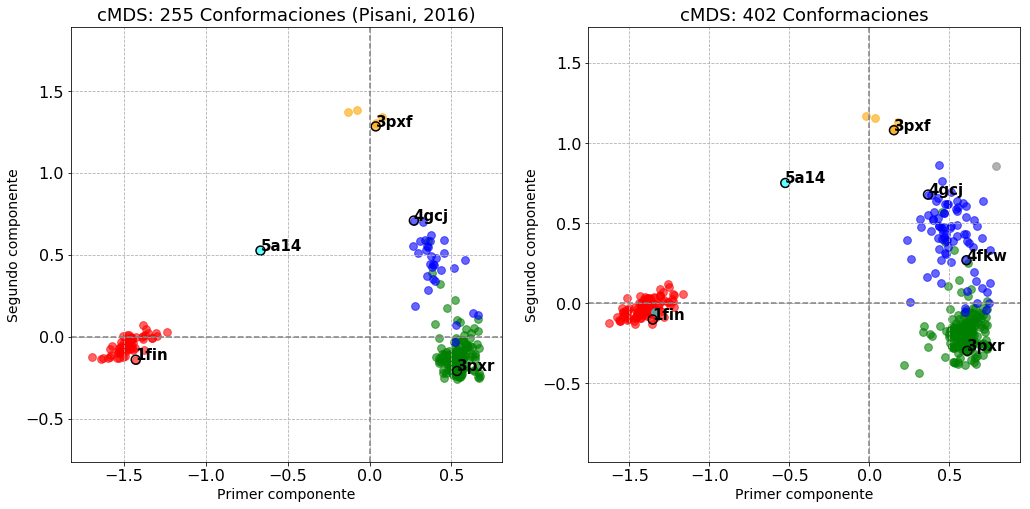

In [122]:
# Estructuras de  referencia que queremos mostrar en la gráfica
ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange", "4fkw": "purple"}
# Etiquetas según el PDB ID de cada estructura
traj_labels_pisani = df_cdk2.index[frames_pisani]
# Se genera la gráfica
fig = plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plot_mds_or_pca(mds = mds_pisani[0], labels = df_cdk2.Labels_conf[frames_pisani],
                dic_of_ref_labels = ref_structs_dict, traj_labels = traj_labels_pisani,
                             title = "cMDS: 255 Conformaciones (Pisani, 2016)")
 
plt.subplot(1, 2, 2)
plot_mds_or_pca(mds = mds_total_402[0], labels = df_cdk2.Labels_conf,
                dic_of_ref_labels = ref_structs_dict, traj_labels = df_cdk2.index,
                             title = "cMDS: 402 Conformaciones")

## Cargamos la nueva trayectoria

In [88]:
path_dinamicas = "../ARCHIVOS/DINAMICA/"

#### Estructuras cristalográficas de la CDK2

In [89]:
# Carga de la trayectoria de las estructuras cristalográficas
file_pdb_traj_pisani = "../ARCHIVOS/CRISTALES/TRAJ_CRISTALS_PDB/PDB_402_cdk2_PISANI_ALL.pdb"
traj_crystals = pyt.load(file_pdb_traj_pisani, mask ="@CA")

#### Trayectorias de dinámica molecular CDK2
- Estructura inicial **1fin**, método: **_Dinámica Molecular con SA_**

In [90]:
# Trayectoria de dinámica molecular
# 1fin SA_DM
file_sa_1fin_r1 = path_dinamicas + "1fin/sa_dm/rep_1/"
traj_sa_1fin_r1 = pyt.load( top = file_sa_1fin_r1 + "sa_dm_1fin.prmtop", 
                            filename = file_sa_1fin_r1 + "4_prod/" + "sa_dm_1fin_prod.nc", mask ="@CA")

- Estructura inicial **1fin**, método: **_Solventes mixtos + SA (etanol)_**

In [91]:
# Trayectoria de dinámica molecular
# 1fin SA_DM
file_mxs_1fin_r1 = path_dinamicas + "1fin/mxs_sa/rep_1/"
traj_mxs_1fin_r1 = pyt.load( top = file_mxs_1fin_r1 + "mxs_1fin.prmtop", 
                            filename = file_mxs_1fin_r1 + "4_prod/" + "mxs_1fin_prod.nc", mask ="@CA")

- Estructura inicial **4fku**, método: **_Dinámica Molecular + SA_**

In [92]:
file_sa_4fku_r1 = path_dinamicas + "4fku/sa_dm/rep_4/"
traj_sa_4fku_r1 = pyt.load( top = file_sa_4fku_r1 + "cdk2.prmtop", 
                            filename = file_sa_4fku_r1 + "3_prod/" + "cdk2_prod.nc", mask ="@CA")

- Estructura inicial **4fku**, método: **_Solventes mixtos + SA (etanol)_**

In [93]:
file_mxs_4fku_r1 = path_dinamicas + "4fku/mxs_sa/rep_mxSA_1/"
traj_mxs_4fku_r1 = pyt.load( top = file_mxs_4fku_r1 + "mxs_cdk2.prmtop", 
                            filename = file_mxs_4fku_r1 + "4_prod/" + "mxs_cdk2_prod.nc", mask ="@CA")

- Estructura inicial **4fku**, método: **_Con ligando_**

In [115]:
file_lig_4fku_r1 = path_dinamicas + "4fku/sa_lig_CS262/rep_4/"
traj_lig_4fku_r1 = pyt.load( top = file_lig_4fku_r1 + "cdk2_LIG.prmtop", 
                            filename = file_lig_4fku_r1 + "4_prod/" + "cdk2_LIG_prod.nc", mask ="@CA")

In [116]:
traj_lig_4fku_r1

pytraj.Trajectory, 1000 frames: 
Size: 0.006661 (GB)
<Topology: 298 atoms, 298 residues, 298 mols, PBC with box type = truncoct>
           

&nbsp; 
### Cálculo de las matrices de RMSD (suplementarias)
Se unen ambas trayectorias para facilitar el alineamiento y el cálculo de la matriz de RMSD:
- **1) Se unen ambas trayectorias.**
    - Se inicaliza un objeto *Trayectoria* con la trayectoria de
    - En *pytraj* las coordenadas de la trayectoria de DM se concatenan al *objeto*

In [96]:
def get_sup_rmsd_pairwise(traj_sample, traj_out_of_sample, ref = 0, mask = F"(:{pisiani_residues})&(@CA)", full_mtx = False):
    temp_traj = traj_sample.copy()
    temp_traj.append_xyz(traj_out_of_sample.xyz)
    # Se realiza el alineamiento con la primera estructura de traj_sample
    pyt.align(temp_traj, F"(:{pisiani_residues})&(@CA)", ref = ref)
    mtx_pairwise_rmsd = pyt.pairwise_rmsd(temp_traj, mask = mask, metric="rmsd")
    n_frames = traj_sample.n_frames
    mtx_rmsd_sup = mtx_pairwise_rmsd[ traj_sample.n_frames: , :traj_sample.n_frames ]
    if full_mtx: return mtx_pairwise_rmsd 
    else: return mtx_rmsd_sup

#### Se generan las matrices suplementarias para cada trayectoria

In [97]:
D_sup_1fin_SA_r1 = get_sup_rmsd_pairwise(traj_crystals, traj_sa_1fin_r1)

In [98]:
D_sup_1fin_MXS_r1 = get_sup_rmsd_pairwise(traj_crystals, traj_mxs_1fin_r1)

In [99]:
D_sup_4fku_MXS_r1 = get_sup_rmsd_pairwise(traj_crystals, traj_mxs_4fku_r1)

In [100]:
D_sup_4fku_SA_r1 = get_sup_rmsd_pairwise(traj_crystals, traj_sa_4fku_r1)

In [117]:
D_sup_4fku_LIG_r1 = get_sup_rmsd_pairwise(traj_crystals, traj_lig_4fku_r1)

#### Ejemplo de visualización de la matriz de disimilitud

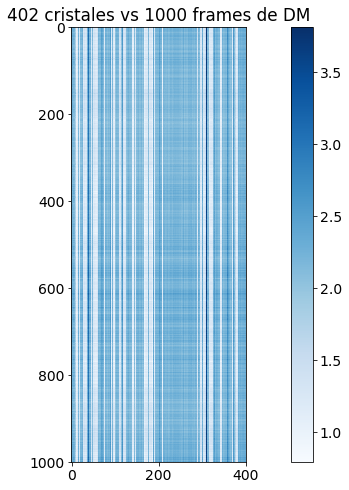

In [102]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 14})
plt.title("402 cristales vs 1000 frames de DM")
plt.imshow(D_sup_1fin_MXS_r1, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

## Proyección de nuevos puntos al cMDS
#### *Output sample projection*

In [103]:
from modulos.MDS import cMDS_proj

In [104]:
mds_1fin_SA_r1 = cMDS_proj(cMDS_obj = mds_total_402, sup_point = D_sup_1fin_SA_r1)

In [105]:
mds_1fin_MXS_r1 = cMDS_proj(cMDS_obj = mds_total_402, sup_point = D_sup_1fin_MXS_r1)

In [106]:
mds_4fku_MXS_r1 = cMDS_proj(cMDS_obj = mds_total_402, sup_point = D_sup_4fku_MXS_r1)

In [107]:
mds_4fku_SA_r1 = cMDS_proj(cMDS_obj = mds_total_402, sup_point = D_sup_4fku_SA_r1)

In [118]:
mds_4fku_LIG_r1 = cMDS_proj(cMDS_obj = mds_total_402, sup_point = D_sup_4fku_LIG_r1)

In [154]:
points_1fin_MXS_r1 = density_estimation(mds_1fin_MXS_r1[:, 0], mds_1fin_MXS_r1[:, 1])

points_1fin_SA_r1 = density_estimation(mds_1fin_SA_r1[:, 0], mds_1fin_SA_r1[:, 1])

points_4fku_MXS_r1 = density_estimation(mds_4fku_MXS_r1[:, 0], mds_4fku_MXS_r1[:, 1])

points_4fku_SA_r1 = density_estimation(mds_4fku_SA_r1[:, 0], mds_4fku_SA_r1[:, 1])

points_4fku_LIG_r1 = density_estimation(mds_4fku_LIG_r1[:, 0], mds_4fku_LIG_r1[:, 1])

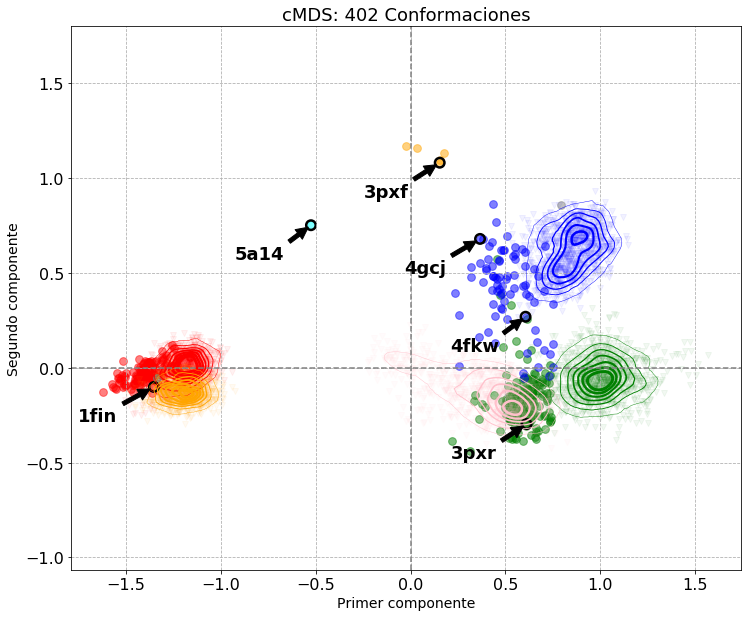

In [217]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(12, 10))
# Plot del cMDS original con 402 estructuras cristalográficas
plot_mds_or_pca(mds = mds_total_402[0], labels = df_cdk2.Labels_conf, traj_labels = df_cdk2.index,
                             title = "cMDS: 402 Conformaciones", alpha = 0.5, xy_lims=[-1.8, -0.8, -0.5, 0.5])
# plot de las proyecciones
colores = ["red", "orange", "blue", "green", "pink"]
lista_trayectorias = [points_1fin_SA_r1, points_1fin_MXS_r1, points_4fku_MXS_r1, 
                      points_4fku_SA_r1, points_4fku_LIG_r1]
intervalos = 8
for traj, color in zip(lista_trayectorias, colores):
    x, y, z = traj
    plt.scatter(x= x, y = y, c = color, alpha = 0.05, marker='v')
    plt.tricontour(x, y, z, intervalos, colors=color, linewidths=np.linspace(0, 3, intervalos))

#cbar = plt.colorbar()
#cbar.set_label('frecuencia')
# Plot de las estructuras de referencia
list_of_ref_names = ref_structs_dict.keys()
plot_anotation_labels(df_cdk2.index, list_of_ref_names, mds_total_402[0][0], mds_total_402)

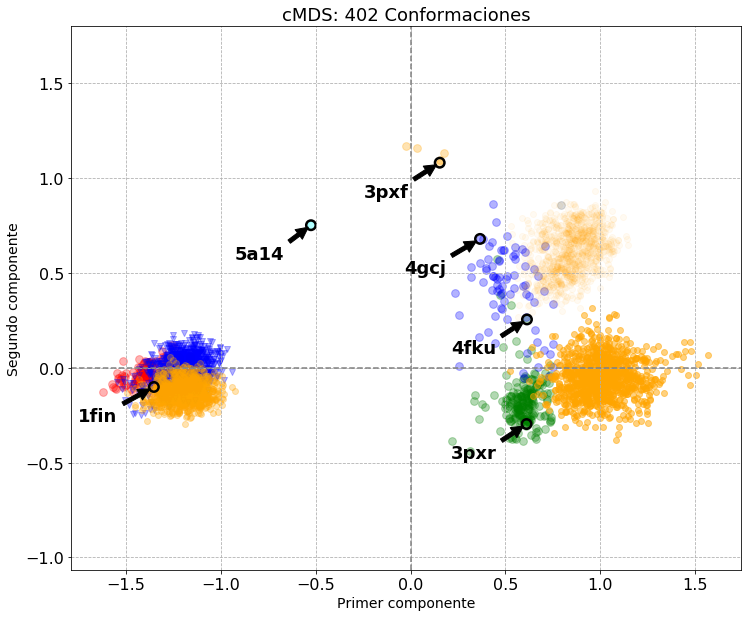